In [1]:
import numpy as np
import pandas as pd
import warnings
import lightgbm as lgb
warnings.filterwarnings("ignore")


# Regularization

In [24]:
kMinGradient = -15.0
kMaxGradient = 15.0
kMinHessian = 1e-16  # Ensure that no data point gets zero hessian
kMaxHessian = 15.0
kEps = 1e-12;  # A denominator in a fraction should not be too small

##### regularized function

def regularization1(t, t_max, t_min):
    
    if(t < t_min):
        return t_min
    if(t > t_max):
        return t_max
    
    return t

regularization = np.vectorize(regularization1)



########## Handelling zero division error (x/0)

def zero_division1(num, deno):
    
    try:
        result = num / deno
    except ZeroDivisionError:
        result = np.inf
     
    return(result)

zero_division = np.vectorize(zero_division1)


# Probability Distribution

## log normal distribution (Z ~ N(0,1))

In [23]:
### Normal
class normal_dist:
    
    kMinGradient = -15.0
    kMaxGradient = 15.0
    kMinHessian = 1e-16  # Ensure that no data point gets zero hessian
    kMaxHessian = 15.0 
    kEps = 1e-12;  # A denominator in a fraction should not be too small

    
    
    def __init__(self, Z, scale):
        self.Z = np.array(Z)
        self.b = np.array(scale)
        
    def normal_pdf(self):
        return(np.exp((-self.Z * self.Z)/2.0) / np.sqrt((2.0 * np.pi)))
        #normal_pdf = np.vectorize(normal_pdf1)


    def normal_cdf(self):
        import math
        math_erf = np.vectorize(math.erf) 
        return (0.5 * (1.0 + math_erf(self.Z / np.sqrt(2.0))))
        #normal_cdf = np.vectorize(normal_cdf1)

    def normal_grad(self):
        return(-self.Z * self.normal_pdf())
        #normal_grad = np.vectorize(normal_grad1)

    def normal_hess(self):
        return((self.Z * self.Z - 1.0) * self.normal_pdf())
        #normal_hess = np.vectorize(normal_hess1)   
    
    @property
    def gnumerator_u(self):
        return(self.normal_grad())
    
    @property
    def gdenominator_u(self):
        return(self.b * self.normal_pdf())
    
    @property
    def gnumerator_c(self): 
        return(- self.normal_pdf())
    
    @property
    def gdenominator_c(self): 
        return(self.b * (1.0 - self.normal_cdf()))
    
    @property
    def hnumerator_u(self):
        return((self.normal_grad() * self.normal_grad()) - self.normal_pdf() * self.normal_hess())
        
    @property
    def hdenominator_u(self):
        return((self.b*self.b * self.normal_pdf()*self.normal_pdf()))
    
    @property
    def hnumerator_c(self):
        return((self.normal_pdf() * self.normal_pdf()) - ((1.0 - self.normal_cdf()) * - self.normal_grad()))
    
    @property
    def hdenominator_c(self):
        return((self.b * self.b * (1.0 - self.normal_cdf())*(1.0 - self.normal_cdf())))

    
    
    
    ###########################################################################
    
    
    #############################################################################
    
    
   

# Get gradient and hessian

In [34]:
def normal_getgrad1(z_value, sigma, grad_numerator_u, grad_denominator_u,
                        grad_numerator_c, grad_denominator_c):
    
    z_sign = z_value > 0.0 
    
    grad_u = zero_division(num = grad_numerator_u, deno = grad_denominator_u)
    grad_c = zero_division(num = grad_numerator_c, deno = grad_denominator_c)

        
    if(grad_denominator_u < kEps or np.isinf(grad_u) or np.isnan(grad_u)):
        if (z_sign):
            grad_u = kMaxGradient
        else:
            grad_u = kMinGradient
                    
    if(grad_denominator_c < kEps or np.isinf(grad_c) or np.isnan(grad_c)):
        if (z_sign):
            grad_c = 0.0
        else:
            grad_c = -15   
                
    return(grad_u, grad_c)   



def normal_gethess1(z_value, sigma, hess_numerator_u, hess_denominator_u,
                        hess_numerator_c, hess_denominator_c):
    
    z_sign = z_value > 0.0 
    hess_u = zero_division(num = hess_numerator_u, deno = hess_denominator_u)
    hess_c = zero_division(num = hess_numerator_c, deno = hess_denominator_c)


    if(hess_denominator_u < kEps or np.isinf(hess_u) or np.isnan(hess_u)):
        if (z_sign):
            hess_u = 1/(sigma*sigma)
        else:
            hess_u = 1/(sigma*sigma)
                    
    if(hess_denominator_c < kEps or np.isinf(hess_c) or np.isnan(hess_c)):
        if (z_sign):
            hess_c = kMinHessian
        else:
            hess_c = 1/(sigma*sigma)  
                
    return(hess_u, hess_c)   

    
normal_getgrad = np.vectorize(normal_getgrad1)
normal_gethess = np.vectorize(normal_gethess1)


In [4]:
s = normal_dist(Z = [-np.inf, 4, -5, 6], scale = 2)

s.gdenominator_c

array([2.00000000e+00, 6.33424837e-05, 1.99999943e+00, 1.97317540e-09])

In [133]:
s.gdenominator_u

array([0.00000000e+00, 2.67660452e-04, 2.97343903e-06, 1.21517657e-08])

In [129]:
restricted_grad(z_value = s.Z , sigma = 2, grad_numerator_u = s.gnumerator_u, 
                       grad_denominator_u = s.gdenominator_u, grad_numerator_c = s.gnumerator_c, 
                       grad_denominator_c = s.gdenominator_c)


(array([-15. ,  -2. ,   2.5,  -3. ]),
 array([-0.00000000e+00, -2.11280357e+00, -7.43359970e-07, -3.07924113e+00]))

In [37]:
#zero_division(num = [1,0], deno = [0,2])
def sw(a,b, c):
    return(a+b*c, a-b)

w = map(sw, [1,0], [2,2], [0,1])  
list(w)


[(1, -1), (2, -2)]

In [76]:
s = normal_dist([2.3, 3], 2 )
s.b

array(2)

In [80]:
np.array([s.b] * len(s.Z))

array([2, 2])

In [79]:
p = list(map(normal_getgrad1, s.Z, np.array([s.b] * len(s.Z)), s.gnumerator_u, s.gdenominator_u,
                                             s.gnumerator_c, s.gdenominator_c))
p

[(array(-1.15), array(-1.32071742)), (array(-1.5), array(-1.64154933))]

In [81]:
p[0][0]
p[0][1]

array(-1.32071742)

In [93]:
def aft_norm (y_true, y_pred):
    
    '''
    #f = np.exp((-z*z)/2.0) / np.sqrt((2.0*np.pi))   #scipy.stats.norm.pdf(z)
    #grad_f = -z*f
    #hess_f = (z*z - 1.0) * f
    #F = scipy.stats.norm.cdf(z)
    #0.5 * (1.0 + math.erf(z / np.sqrt(2.0)))           
    #s = 1 - scipy.stats.norm.cdf(z)
                                         
    grad_n =  ind_train*(normal_grad(z) / (b*normal_pdf(z))) + ((1.0 - ind_train)*(-normal_pdf(z))) / (b * (1.0 - normal_cdf(z)))
    
    hessian_u = ind_train * ((normal_grad(z)*normal_grad(z)) - normal_pdf(z)*normal_hess(z)) / (b*b*normal_pdf(z)*normal_pdf(z)) 
    hessian_c = ((1-ind_train) * ((-normal_pdf(z)* -normal_pdf(z)) - ((1.0 - normal_cdf(z)) * -normal_grad(z))) / (b*b*(1.0 - normal_cdf(z))*(1.0 - normal_cdf(z))))
    
    hess_n =  hessian_u + hessian_c 
    
    '''
    
    b = 2.0
    z = (y_true - y_pred)/b
    
    s = normal_dist(Z = z, scale = b)   
    sigma = np.array([s.b] * len(s.Z))
    gradient_u, gradient_c = normal_getgrad(z_value = s.Z, sigma = s.b, grad_numerator_u = s.gnumerator_u, 
                                             grad_denominator_u = s.gdenominator_u,
                                             grad_numerator_c = s.gnumerator_c, 
                                             grad_denominator_c = s.gdenominator_c)


#    p = list(map(normal_getgrad1, s.Z, sigma, s.gnumerator_u, s.gdenominator_u,
#                                             s.gnumerator_c, s.gdenominator_c))


#    gradient_u = p[0][0]
#    gradient_c = p[0][1] 

    
    g = ind_train * gradient_u + (1 - ind_train) * gradient_c
    grad = regularization(t = g, t_min = kMinGradient, t_max = kMaxGradient)
    
    
    hessian_u, hessian_c = normal_gethess(z_value = s.Z, sigma = s.b, hess_numerator_u = s. hnumerator_u, 
                                           hess_denominator_u = s.hdenominator_u, hess_numerator_c = s.hnumerator_c, 
                                           hess_denominator_c = s.hdenominator_c)
    
#    q = list(map(normal_gethess1, s.Z, sigma, s.hnumerator_u, s.hdenominator_u, s.hnumerator_c, 
#                                             s.hdenominator_c))
    
#    hessian_u = q[0][0]
#    hessian_c = q[0][1]

    
    
    h = ind_train*hessian_u + (1 - ind_train)*hessian_c
    
    hess = regularization(t = h, t_min = kMinHessian, t_max = kMaxHessian)

    
    return grad, hess


In [91]:
df = pd.read_csv('DLBCL.csv')
y = np.log(df['time']) 
X = df.iloc[:,3:]
ind_train = df['status']
X.head()


,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a7390,a7391,a7392,a7393,a7394,a7395,a7396,a7397,a7398,a7399
0,-0.2210,-0.17860,-0.05025,-0.1922,-0.2944,0.75440,1.0030,0.2628,-0.2482,0.1303,...,0.2071,-0.74500,-0.06380,-0.12240,0.72480,-0.13440,0.52030,0.8013,0.93980,0.04403
1,-0.1946,-0.22380,-0.12600,-0.1614,-0.1994,-0.32301,0.2532,0.9026,0.6193,0.7257,...,0.2286,-0.14917,0.31320,-0.15710,0.15220,-0.33700,-0.25400,0.2317,-0.02250,-0.20954
2,-0.3179,-0.15850,-0.48560,-0.3483,-0.4490,-0.17260,0.2333,1.2680,0.9186,-0.0896,...,0.6340,-0.36613,-0.26613,-0.39330,-1.18100,0.08445,-0.11290,0.6758,-0.31463,-0.06200
3,0.4269,0.26242,1.70900,0.7984,0.4512,0.31030,0.5402,0.5965,0.4384,0.4011,...,0.3165,0.34965,0.14732,0.29881,-0.00655,0.01305,0.43361,0.2822,0.11990,0.19310
4,0.5116,0.79760,1.46400,1.0520,1.0410,-0.22900,1.4150,1.8440,1.8400,1.6710,...,-0.0597,0.05024,0.66020,-0.03310,-0.20860,-0.11076,0.21551,-0.3900,-0.30910,-0.08185


In [87]:
import lightgbm as lgb
aft_model = lgb.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
aft_model.set_params(**{'objective': aft_norm},
               metrics = ['rmse', 'l1'], 
               boosting_type = "goss", 
               num_iterations = 1000,
               n_jobs = 4, 
               max_depth = 3,   
               learning_rate = 0.001,
               importance_type = "gain")# early_stopping_round = 10)
# fitting model 
aft_model.fit(
    X,
    y,
    eval_set = [(X, y)], 
#    eval_metric = nlog_like_sk,
    verbose = 50

)


[50]	training's rmse: 1.82503	training's l1: 1.4181
[100]	training's rmse: 1.78542	training's l1: 1.37181
[150]	training's rmse: 1.75206	training's l1: 1.32967
[200]	training's rmse: 1.72454	training's l1: 1.2934
[250]	training's rmse: 1.70245	training's l1: 1.26083
[300]	training's rmse: 1.68537	training's l1: 1.23117
[350]	training's rmse: 1.67289	training's l1: 1.20378
[400]	training's rmse: 1.6646	training's l1: 1.18006
[450]	training's rmse: 1.66011	training's l1: 1.15912
[500]	training's rmse: 1.65904	training's l1: 1.14342
[550]	training's rmse: 1.66104	training's l1: 1.13197
[600]	training's rmse: 1.66577	training's l1: 1.12426
[650]	training's rmse: 1.67292	training's l1: 1.11908
[700]	training's rmse: 1.68222	training's l1: 1.11667
[750]	training's rmse: 1.6934	training's l1: 1.11745
[800]	training's rmse: 1.70624	training's l1: 1.12339
[850]	training's rmse: 1.72054	training's l1: 1.13294
[900]	training's rmse: 1.73611	training's l1: 1.14628
[950]	training's rmse: 1.75279	tr

LGBMRegressor(boosting_type='goss', importance_type='gain', learning_rate=0.001,
              max_depth=3, metrics=['rmse', 'l1'], n_jobs=4,
              num_iterations=1000,
              objective=<function aft_norm at 0x130858940>)

In [95]:
import lightgbm as lgb
aft_model = lgb.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
aft_model.set_params(**{'objective': aft_norm},
               metrics = ['rmse', 'l1'], 
               boosting_type = "goss", 
               num_iterations = 1000,
               n_jobs = 4, 
               max_depth = 3,   
               learning_rate = 0.01,
               importance_type = "gain")# early_stopping_round = 10)
# fitting model 
aft_model.fit(
    X,
    y,
    eval_set = [(X, y)], 
#    eval_metric = nlog_like_sk,
    verbose = 50

)



[50]	training's rmse: 1.38188	training's l1: 0.978002
[100]	training's rmse: 1.16655	training's l1: 0.749477
[150]	training's rmse: 1.14616	training's l1: 0.735446
[200]	training's rmse: 1.11578	training's l1: 0.737314
[250]	training's rmse: 1.08511	training's l1: 0.735927
[300]	training's rmse: 1.07297	training's l1: 0.759941
[350]	training's rmse: 1.0755	training's l1: 0.791236
[400]	training's rmse: 1.07516	training's l1: 0.806443
[450]	training's rmse: 1.06907	training's l1: 0.818723
[500]	training's rmse: 1.06939	training's l1: 0.833116
[550]	training's rmse: 1.07726	training's l1: 0.853194
[600]	training's rmse: 1.09229	training's l1: 0.875189
[650]	training's rmse: 1.12329	training's l1: 0.908718
[700]	training's rmse: 1.14378	training's l1: 0.925034
[750]	training's rmse: 1.17704	training's l1: 0.952151
[800]	training's rmse: 1.22173	training's l1: 0.991577
[850]	training's rmse: 1.24441	training's l1: 1.00309
[900]	training's rmse: 1.25503	training's l1: 1.0048
[950]	training'

LGBMRegressor(boosting_type='goss', importance_type='gain', learning_rate=0.01,
              max_depth=3, metrics=['rmse', 'l1'], n_jobs=4,
              num_iterations=1000,
              objective=<function aft_norm at 0x12efc4e50>)

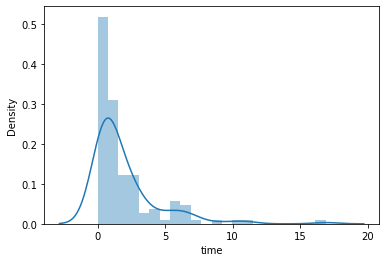

In [15]:
import seaborn as sns
sns.distplot(np.exp(y.loc[df['status'] == 1]))

true = np.exp(y.loc[df['status'] == 1])

<AxesSubplot:ylabel='Density'>

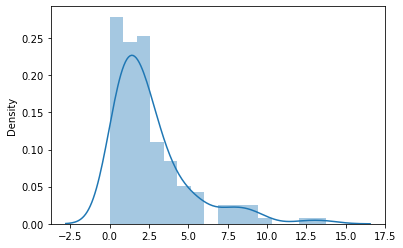

In [16]:
pred = np.exp(aft_model.predict(X))
pred = pd.Series(pred).loc[df['status'] == 1]
sns.distplot(pred)

In [161]:
b

4       True
5       True
6       True
7      False
8      False
       ...  
234    False
235     True
236    False
238    False
239    False
Name: time, Length: 138, dtype: bool

In [17]:
b = true < np.median(true)
a = pd.Series(data = None, index = b.index)

a[b] = 0
a[~b] = 1


In [18]:
c = pred < np.median(pred)
d = pd.Series(index = c.index)
d[c] = 0
d[~c] = 1
pd.DataFrame({'true': a, 'pred': d})

,true,pred
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
...,...,...
234,1.0,1.0
235,0.0,0.0
236,1.0,1.0
238,1.0,1.0


In [19]:
from sklearn.metrics import confusion_matrix, mean_absolute_percentage_error

confusion_matrix(a,d)

array([[62,  7],
       [ 7, 62]])

In [20]:
mean_absolute_percentage_error(true,pred)

2.191910441280388

In [21]:
q = aft_model.feature_importances_ > np.quantile(aft_model.feature_importances_, 0.95)
q

array([False, False, False, ..., False, False, False])

## log logistic (Z ~ logistic(0,1))

In [41]:
#class logistic_dist:
    
    
#    def __init__(self, Z, scale):

#        self.Z = Z
#        self.b = scale
        
    

In [115]:
def logistic_pdf1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    sqrt_denominator = 1 + w
    if (np.isinf(w) or np.isinf(w * w)):
        return (0.0)
    else:
        return w / (sqrt_denominator * sqrt_denominator)

logistic_pdf = np.vectorize(logistic_pdf1)    
           
def logistic_cdf1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    if(np.isinf(w)):
        return(1.0)
    else:  
        return((w / (1 + w))) 
    
logistic_cdf = np.vectorize(logistic_cdf1)    


    
def logistic_grad1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
        
    if (np.isinf(w) or np.isinf(w * w)):
        return (0.0)
    else:
        return (logistic_pdf(Z) * ((1 - w) / (1 + w)))

logistic_grad = np.vectorize(logistic_grad1)    
        

def logistic_hess1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    sqrt_denominator = 1 + w
        
    if (np.isinf(w) or np.isinf(w * w)):
        return (0.0)
    else:
        return (logistic_pdf(Z) * ((w * w - 4 * w + 1.0) / (sqrt_denominator * sqrt_denominator)))

logistic_hess = np.vectorize(logistic_hess1)    
        
     
    #@property
def logistic_gnumerator_u(Z):
    return(logistic_grad(Z))
    
    #@property
def logistic_gdenominator_u(Z, b):
    return(b * logistic_pdf(Z))
    
    #@property
def logistic_gnumerator_c(Z): 
    return(- logistic_pdf(Z))
    
    #@property
def logistic_gdenominator_c(Z, b): 
    return(b * (1.0 - logistic_cdf(Z)))
    
    #@property
def logistic_hnumerator_u(Z):
    return((logistic_grad(Z) * logistic_grad(Z)) - logistic_pdf(Z) * logistic_hess(Z))
        
    #@property
def logistic_hdenominator_u(Z, b):
    return((b * b * logistic_pdf(Z) * logistic_pdf(Z)))
    
    #@property
def logistic_hnumerator_c(Z):
    return((logistic_pdf(Z) * logistic_pdf(Z)) - ((1.0 - logistic_cdf(Z)) * - logistic_grad(Z)))
    
    #@property
def logistic_hdenominator_c(Z, b):
    return((b * b * (1.0 - logistic_cdf(Z))*(1.0 - logistic_cdf(Z))))


        
        
        




# Get gradient and hessian (log-logistic)

In [116]:
def logistic_getgrad1(z_value, sigma, grad_numerator_u, grad_denominator_u,
                        grad_numerator_c, grad_denominator_c):
    
    z_sign = z_value > 0.0 
    
    grad_u = zero_division(num = grad_numerator_u, deno = grad_denominator_u)
    grad_c = zero_division(num = grad_numerator_c, deno = grad_denominator_c)

        
    if(grad_denominator_u < kEps or np.isinf(grad_u) or np.isnan(grad_u)):
        if (z_sign):
            grad_u = 1/sigma
        else:
            grad_u = -1/sigma
                    
    if(grad_denominator_c < kEps or np.isinf(grad_c) or np.isnan(grad_c)):
        if (z_sign):
            grad_c = 0.0
        else:
            grad_c = -1/sigma   
                
    return(grad_u, grad_c)   



def logistic_gethess1(z_value, sigma, hess_numerator_u, hess_denominator_u,
                        hess_numerator_c, hess_denominator_c):
    
    z_sign = z_value > 0.0 
    hess_u = zero_division(num = hess_numerator_u, deno = hess_denominator_u)
    hess_c = zero_division(num = hess_numerator_c, deno = hess_denominator_c)


    if(hess_denominator_u < kEps or np.isinf(hess_u) or np.isnan(hess_u)):
        if (z_sign):
            hess_u = kMinHessian
        else:
            hess_u = kMinHessian
                    
    if(hess_denominator_c < kEps or np.isinf(hess_c) or np.isnan(hess_c)):
        if (z_sign):
            hess_c = kMinHessian
        else:
            hess_c = kMinHessian  
                
    return(hess_u, hess_c)   

    
logistic_getgrad = np.vectorize(logistic_getgrad1)
logistic_gethess = np.vectorize(logistic_gethess1)



In [113]:
def aft_logistic (y_true, y_pred):
    
        
    b = 2.0
    z = (y_true - y_pred)/b
    
    #s = logistic_dist(Z = z, scale = b)    
    gradient_u, gradient_c = logistic_getgrad(z_value = z, sigma = b, grad_numerator_u = logistic_gnumerator_u(z), 
                                             grad_denominator_u = logistic_gdenominator_u(z, b),
                                             grad_numerator_c = logistic_gnumerator_c(z), 
                                             grad_denominator_c = logistic_gdenominator_c(z,b))
    g = ind_train * gradient_u + (1 - ind_train) * gradient_c
    grad = regularization(t = g, t_min = kMinGradient, t_max = kMaxGradient)
    
    
    hessian_u, hessian_c = logistic_gethess(z_value = z, sigma = b, hess_numerator_u = logistic_hnumerator_u(z), 
                                           hess_denominator_u = logistic_hdenominator_u(z, b), 
                                           hess_numerator_c = logistic_hnumerator_c(z), 
                                           hess_denominator_c = logistic_hdenominator_c(z, b))

    h = ind_train*hessian_u + (1 - ind_train)*hessian_c
    
    hess = regularization(t = h, t_min = kMinHessian, t_max = kMaxHessian)

    
    return grad, hess



In [117]:
aft_model = lgb.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
aft_model.set_params(**{'objective': aft_logistic},
               metrics = ['rmse', 'l1'], 
               boosting_type = "goss", 
               num_iterations = 500,
               n_jobs = 4, 
               max_depth = 3,   
               learning_rate = 0.01,
               importance_type = "gain")# early_stopping_round = 10)
# fitting model 
aft_model.fit(
    X,
    y,
    eval_set = [(X, y)], 
#    eval_metric = nlog_like_sk,
    verbose = 10

)




[10]	training's rmse: 1.71151	training's l1: 1.30585
[20]	training's rmse: 1.5814	training's l1: 1.16072
[30]	training's rmse: 1.47441	training's l1: 1.03782
[40]	training's rmse: 1.39385	training's l1: 0.93531
[50]	training's rmse: 1.33721	training's l1: 0.859448
[60]	training's rmse: 1.30323	training's l1: 0.814219
[70]	training's rmse: 1.28446	training's l1: 0.79541
[80]	training's rmse: 1.27989	training's l1: 0.796909
[90]	training's rmse: 1.2828	training's l1: 0.807933
[100]	training's rmse: 1.29323	training's l1: 0.83043
[110]	training's rmse: 1.30805	training's l1: 0.853232
[120]	training's rmse: 1.32415	training's l1: 0.876305
[130]	training's rmse: 1.34281	training's l1: 0.897842
[140]	training's rmse: 1.35829	training's l1: 0.915314
[150]	training's rmse: 1.3742	training's l1: 0.937435
[160]	training's rmse: 1.39023	training's l1: 0.959549
[170]	training's rmse: 1.39974	training's l1: 0.977231
[180]	training's rmse: 1.41508	training's l1: 0.996277
[190]	training's rmse: 1.437

LGBMRegressor(boosting_type='goss', importance_type='gain', learning_rate=0.01,
              max_depth=3, metrics=['rmse', 'l1'], n_jobs=4, num_iterations=500,
              objective=<function aft_logistic at 0x13bbcbee0>)

## Weibull (Z ~ EV(0,1))


In [106]:

def extreme_pdf1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    if(np.isinf(w)):
        return (0.0)
    else:
        return(w * np.exp(-w))
extreme_pdf = np.vectorize(extreme_pdf1)    
    
    
def extreme_cdf1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    if(np.isinf(w)):
        return (1.0)
    else:
        return(1 - exp(-w))
extreme_cdf = np.vectorize(extreme_cdf1)    


def extreme_grad1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    if(np.isinf(w)):
        return (0.0)
    else:
        return extreme_pdf(Z) * (1.0 - w)
extreme_grad = np.vectorize(extreme_grad1)    

    
def extreme_hess1(Z):
    exp = np.vectorize(np.exp)
    w = exp(Z)
    if(np.isinf(w)):
        return (0.0)
    else:
        return extreme_pdf(Z) * (1.0 - 3 * w + w * w)
extreme_hess = np.vectorize(extreme_hess1)    

    
    
    
#    @property
def extreme_gnumerator_u(Z):
    return(extreme_grad(Z))
    
#    @property
def extreme_gdenominator_u(Z, b):
    return(b * extreme_pdf(Z))
    
#    @property
def extreme_gnumerator_c(Z): 
    return(- extreme_pdf(Z))
    
#    @property
def extreme_gdenominator_c(Z, b): 
    return(b * (1.0 - extreme_cdf(Z)))
    
#    @property
def extreme_hnumerator_u(Z):
    return((extreme_grad(Z) * extreme_grad(Z)) - extreme_pdf(Z) * extreme_hess(Z))
        
#    @property
def extreme_hdenominator_u(Z, b):
    return((b*b * extreme_pdf(Z)*extreme_pdf(Z)))
    
#    @property
def extreme_hnumerator_c(Z):
    return((extreme_pdf(Z) * extreme_pdf(Z)) - ((1.0 - extreme_cdf(Z))* - extreme_grad(Z)))
    
#    @property
def extreme_hdenominator_c(Z, b):
    return((b*b * (1.0 - extreme_cdf(Z))*(1.0 - extreme_cdf(Z))))


        
        
        



    

In [100]:
kMaxHessian

15.0

In [107]:
def extreme_getgrad1(z_value, sigma, grad_numerator_u, grad_denominator_u,
                        grad_numerator_c, grad_denominator_c):
    
    z_sign = z_value > 0.0 
    
    grad_u = zero_division(num = grad_numerator_u, deno = grad_denominator_u)
    grad_c = zero_division(num = grad_numerator_c, deno = grad_denominator_c)

        
    if(grad_denominator_u < kEps or np.isinf(grad_u) or np.isnan(grad_u)):
        if (z_sign):
            grad_u = 1/sigma
        else:
            grad_u = kMinGradient
                    
    if(grad_denominator_c < kEps or np.isinf(grad_c) or np.isnan(grad_c)):
        if (z_sign):
            grad_c = 0.0
        else:
            grad_c = kMinGradient 
                
    return(grad_u, grad_c)   



def extreme_gethess1(z_value, sigma, hess_numerator_u, hess_denominator_u,
                        hess_numerator_c, hess_denominator_c):
    
    z_sign = z_value > 0.0 
    hess_u = zero_division(num = hess_numerator_u, deno = hess_denominator_u)
    hess_c = zero_division(num = hess_numerator_c, deno = hess_denominator_c)


    if(hess_denominator_u < kEps or np.isinf(hess_u) or np.isnan(hess_u)):
        if (z_sign):
            hess_u = kMinHessian
        else:
            hess_u = kMaxHessian
                    
    if(hess_denominator_c < kEps or np.isinf(hess_c) or np.isnan(hess_c)):
        if (z_sign):
            hess_c = kMinHessian
        else:
            hess_c = kMaxHessian  
                
    return(hess_u, hess_c)   

    
extreme_getgrad = np.vectorize(extreme_getgrad1)
extreme_gethess = np.vectorize(extreme_gethess1)




In [110]:
def aft_weibull (y_true, y_pred):
    
        
    b = 2.0
    z = (y_true - y_pred)/b
    
    #s = logistic_dist(Z = z, scale = b)    
    gradient_u, gradient_c = extreme_getgrad(z_value = z, sigma = b, grad_numerator_u = extreme_gnumerator_u(z), 
                                             grad_denominator_u = extreme_gdenominator_u(z, b),
                                             grad_numerator_c = extreme_gnumerator_c(z), 
                                             grad_denominator_c = extreme_gdenominator_c(z,b))
    g = ind_train * gradient_u + (1 - ind_train) * gradient_c
    grad = regularization(t = g, t_min = kMinGradient, t_max = kMaxGradient)
    
    
    hessian_u, hessian_c = extreme_gethess(z_value = z, sigma = b, hess_numerator_u = extreme_hnumerator_u(z), 
                                           hess_denominator_u = extreme_hdenominator_u(z, b), 
                                           hess_numerator_c = extreme_hnumerator_c(z), 
                                           hess_denominator_c = extreme_hdenominator_c(z, b))

    h = ind_train*hessian_u + (1 - ind_train)*hessian_c
    
    hess = regularization(t = h, t_min = kMinHessian, t_max = kMaxHessian)

    
    return grad, hess




In [111]:
aft_model = lgb.LGBMRegressor() 

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores
aft_model.set_params(**{'objective': aft_weibull},
               metrics = ['rmse', 'l1'], 
               boosting_type = "goss", 
               num_iterations = 500,
               n_jobs = 4, 
               max_depth = 3,   
               learning_rate = 0.01,
               importance_type = "gain")# early_stopping_round = 10)
# fitting model 
aft_model.fit(
    X,
    y,
    eval_set = [(X, y)], 
#    eval_metric = nlog_like_sk,
    verbose = 10

)






[10]	training's rmse: 1.79943	training's l1: 1.39631
[20]	training's rmse: 1.7386	training's l1: 1.32935
[30]	training's rmse: 1.68369	training's l1: 1.26829
[40]	training's rmse: 1.63406	training's l1: 1.21172
[50]	training's rmse: 1.58927	training's l1: 1.1577
[60]	training's rmse: 1.55229	training's l1: 1.10624
[70]	training's rmse: 1.52016	training's l1: 1.056
[80]	training's rmse: 1.49054	training's l1: 1.00647
[90]	training's rmse: 1.46583	training's l1: 0.965932
[100]	training's rmse: 1.44521	training's l1: 0.93365
[110]	training's rmse: 1.45648	training's l1: 0.928056
[120]	training's rmse: 1.47706	training's l1: 0.929236
[130]	training's rmse: 1.48943	training's l1: 0.933563
[140]	training's rmse: 1.51722	training's l1: 0.945868
[150]	training's rmse: 1.54163	training's l1: 0.961288
[160]	training's rmse: 1.56039	training's l1: 0.975968
[170]	training's rmse: 1.58745	training's l1: 1.00195
[180]	training's rmse: 1.61268	training's l1: 1.0321
[190]	training's rmse: 1.63633	trai

LGBMRegressor(boosting_type='goss', importance_type='gain', learning_rate=0.01,
              max_depth=3, metrics=['rmse', 'l1'], n_jobs=4, num_iterations=500,
              objective=<function aft_weibull at 0x12efcaaf0>)